In [2]:
import pandas as pd
import numpy as np
import os
import numpy as np
import random
from datetime import datetime
import time
import math
import gdown
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Softmax

try: 
    AUTOTUNE = tf.data.AUTOTUNE
except: 
    AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [4]:
## Hyper-Parameter 설정
# image resolution
# 최적화 된 값은 아님
RES = 32
# class 수 
N_CLASS = 10
# batch size
N_BATCH = 64
# epoch 수
N_EPOCH = 60
# learning rate
LR = 0.0001

In [25]:
# 데이터 셋 호출 
data_dir = "."
train_dir = os.path.join(data_dir, 'seg_train', 'seg_train')
val_dir = os.path.join(data_dir, 'seg_test', 'seg_test')

train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    # shuffle=True,
    image_size=(RES, RES),
    batch_size=N_BATCH
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    # shuffle=False,
    image_size=(RES, RES),
    batch_size=N_BATCH
)

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [26]:
# 데이터 셋 호출 
(x_train2, y_train2), (x_test2, y_test2) = tf.keras.datasets.cifar10.load_data()
y_train2 = tf.keras.utils.to_categorical(y_train2, 10)
# y_train2

train_ds2 = tf.data.Dataset.from_tensor_slices((x_train2, y_train2))
# train_ds2 = train_ds.shuffle(1000).batch(N_BATCH)

test_ds2 = tf.data.Dataset.from_tensor_slices((x_test2, y_test2))
test_ds2 = test_ds2.batch(N_BATCH)

In [27]:
for image, label in train_ds.take(1):
    pass 

for image2, label2 in train_ds2.take(1):
    pass 

# plt.imshow(image) 
# plt.imshow(image2) 
image.shape, image2.shape
    

(TensorShape([32, 32, 32, 3]), TensorShape([32, 32, 3]))

# MoileNet

In [5]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
mobilenetv3 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(RES, RES, 3))

In [6]:
mobilenetv3.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 16, 16, 16)   432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 16, 16, 16)   64          Conv[0][0]                       
___________________________________________________________________________________

In [35]:
def create_model():
    inputs = tf.keras.Input(shape=(RES, RES, 3))

    x = preprocess_input(inputs) 
    x = mobilenetv3(x) # outputd이 7 by 7 이 나옴
    x = GlobalAveragePooling2D()(x) # outputd이 1 by 1 이 나옴
    x = Dense(N_CLASS)(x)
    x = BatchNormalization()(x)
    outputs = Softmax()(x)
    model = keras.Model(inputs=inputs, outputs=outputs) 

    return model

In [36]:
model = create_model()

In [37]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
MobilenetV3small (Functional (None, 1, 1, 1024)        1529968   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
_________________________________________________________________
batch_normalization_1 (Batch (None, 10)                40        
_________________________________________________________________
softmax_1 (Softmax)          (None, 10)                0         
Total params: 1,540,258
Trainable params: 1,528,126
Non-trainable params: 12,132
____________________________________________

In [7]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [8]:
train_loss = tf.keras.metrics.Mean()
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

test_loss = tf.keras.metrics.Mean()
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [40]:
@tf.function 
def train_step(image, label): 
    with tf.GradientTape() as tape: 
        predictions = model(image)
        loss = loss_object(label, predictions) 
        
    gradient = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))
    
    train_loss(loss) 
    train_accuracy(label, predictions)

In [41]:
@tf.function 
def test_step(image, label): 
    with tf.GradientTape() as tape: 
        predictions = model(image)
        loss = loss_object(label, predictions) 
        
    # gradient = tape.gradient(loss, model.trainable_variables)
    # optimizer.apply_gradient(zip(gradient, model.trainable_variables))
    
    test_loss(loss) 
    test_accuracy(label, predictions)

In [42]:
for epoch in range(N_EPOCH):
    
    for image, label in train_ds: 
        train_step(image, label)
        
    for image, label in test_ds: 
        test_step(image, label)
        
    temp = 'epoch : {}, loss : {}, accuracy : {}, test_loss : {}, test_accuracy : {}'
    print(temp.format(epoch+1
                    , train_loss.result() 
                    , train_accuracy.result() * 100 
                    , test_loss.result() 
                    , test_accuracy.result() * 100))
        

epoch : 1, loss : 2.3129591941833496, accuracy : 9.866000175476074, test_loss : 2.3132059574127197, test_accuracy : 10.0


## Make map file

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

train_ds2 = tf.data.Dataset.from_tensor_slices((train_images, train_labels)) 

map = pd.DataFrame(columns=['image_idx', 'label', '0', '1', '2', '3', '4', '5', '6' , '7', '8', '9'])
idx = 0
for image, label in train_ds2:
  pred = model.predict(image[tf.newaxis, ...])
  map = map.append({'image_idx' : idx, 
                    'label' : int(label.numpy()[0]), 
                    '0' : pred[0][0],
                    '1' : pred[0][1], 
                    '2' : pred[0][2], 
                    '3' : pred[0][3], 
                    '4' : pred[0][4], 
                    '5' : pred[0][5], 
                    '6' : pred[0][6], 
                    '7' : pred[0][7], 
                    '8' : pred[0][8], 
                    '9' : pred[0][9]}, ignore_index=True)
  idx += 1
  
print(map)
map.to_csv('map.csv')


       image_idx  label         0  ...             7         8             9
0            0.0    6.0  0.000001  ...  4.862356e-07  0.000008  9.496373e-07
1            1.0    9.0  0.000008  ...  1.454647e-07  0.000001  9.999882e-01
2            2.0    9.0  0.002709  ...  2.957324e-05  0.000026  9.966539e-01
3            3.0    4.0  0.000002  ...  4.281156e-05  0.000005  1.142413e-05
4            4.0    1.0  0.000698  ...  2.953027e-08  0.000004  8.937969e-07
...          ...    ...       ...  ...           ...       ...           ...
49995    49995.0    2.0  0.021420  ...  6.178618e-07  0.030295  6.345319e-07
49996    49996.0    6.0  0.000002  ...  4.693326e-06  0.000010  2.003440e-05
49997    49997.0    9.0  0.000179  ...  6.097836e-06  0.001620  9.979510e-01
49998    49998.0    1.0  0.000384  ...  1.030339e-07  0.000009  6.504501e-06
49999    49999.0    1.0  0.000037  ...  8.417117e-08  0.004187  3.773291e-05

[50000 rows x 12 columns]


### cutmix 알고리즘 (feat. improving 희망 버전) 

In [8]:
def aug(image, label):
    image = tf.image.random_crop(image, [RES, RES, 3])
    image = tf.image.random_flip_left_right(image)
    return image, label

In [9]:
map = pd.read_csv('map.csv')
map

,Unnamed: 0,image_idx,label,0,1,2,3,4,5,6,7,8,9
0,0,0.0,6.0,0.000001,0.000010,2.779686e-05,1.790632e-05,4.281525e-06,3.228066e-06,9.999264e-01,4.862356e-07,0.000008,9.496373e-07
1,1,1.0,9.0,0.000008,0.000003,4.672599e-11,8.886146e-08,1.796064e-08,2.464894e-11,2.075124e-10,1.454647e-07,0.000001,9.999882e-01
2,2,2.0,9.0,0.002709,0.000570,9.074086e-08,2.599335e-06,4.220522e-06,1.926461e-08,4.843626e-06,2.957324e-05,0.000026,9.966539e-01
3,3,3.0,4.0,0.000002,0.000008,2.172263e-05,3.851811e-05,9.987143e-01,8.316631e-06,1.147147e-03,4.281156e-05,0.000005,1.142413e-05
4,4,4.0,1.0,0.000698,0.999091,2.000231e-04,4.967809e-10,5.492459e-10,1.803944e-09,5.261133e-06,2.953027e-08,0.000004,8.937969e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,49995.0,2.0,0.021420,0.002624,9.455870e-01,3.689165e-05,9.125778e-06,2.605868e-05,4.972392e-07,6.178618e-07,0.030295,6.345319e-07
49996,49996,49996.0,6.0,0.000002,0.000182,8.873791e-04,9.557485e-04,3.220922e-05,1.170667e-04,9.977881e-01,4.693326e-06,0.000010,2.003440e-05
49997,49997,49997.0,9.0,0.000179,0.000211,2.056990e-08,6.988997e-06,2.496424e-05,3.701066e-09,2.598574e-08,6.097836e-06,0.001620,9.979510e-01
49998,49998,49998.0,1.0,0.000384,0.999470,2.116722e-05,1.375212e-09,1.610353e-08,9.324150e-09,1.100292e-04,1.030339e-07,0.000009,6.504501e-06


In [10]:
# map.loc[2, 'image_idx']
# a = map.iloc[3, 2:].values

# print(type(a))
# print(np.argsort(np.max(a, axis=0))[-2])
# print(np.max(a, axis=0))
# print(np.argsort(a, axis=0)[-2])
# ttmap = map[map['label'] == 5].sample(n=1)
# ttmap['image_idx']
# len(x_train)
# test_map = map[map['label'] == 5].sample(n=1)
# aa = test_map['image_idx'].values[0]
# print(tf.convert_to_tensor(aa, dtype=tf.int32))

# print(aa)
# x_train[25770, :,: ]
# x_train[0, :,: ]
print(tf.random.uniform((), 0, 64, tf.int32))
# print(len(train_ds))

tf.Tensor(56, shape=(), dtype=int32)


In [11]:
def get_random_map(i, rank):
    # 2번째로 높은 값 출력
    choiced = np.argsort(map.iloc[i, 2:].values, axis=0)[-rank]
    choiced_map = map[map['label'] == choiced].sample(n=1)

    while choiced_map['image_idx'].values == i:
        choiced_map = map[map['label'] == choiced].sample(n=1)
        
    # print(choiced_map['image_idx'])
    # return int(choiced_map['image_idx'].values[0])
    return tf.convert_to_tensor(choiced_map['image_idx'].values[0], dtype=tf.int32)

In [15]:
def improved_cutmix(image, label): 
    # print(1)
    imgs = []; labs = []

    # for image, label in zip(x_train, y_train):
    for i in range(len(x_train)):
    # for i in range(3):
        # print(label)
        APPLY = tf.cast(tf.random.uniform(()) >= 0.5, tf.int32) 
        idx = tf.random.uniform((), 0, N_BATCH, tf.int32)
        # idx = get_random_map(i, 2) 

        w = RES 
        h = RES 

        lam = tf.random.uniform(())
        cut_ratio = tf.math.sqrt(1.-lam) 
        cut_w = tf.cast(w * cut_ratio, tf.int32) * APPLY
        cut_h = tf.cast(h * cut_ratio, tf.int32) * APPLY

        cx = tf.random.uniform((), int(w/8), int(7/8*w), tf.int32)
        cy = tf.random.uniform((), int(h/8), int(7/8*h), tf.int32)

        xmin = tf.clip_by_value(cx - cut_w//2, 0, w)
        ymin = tf.clip_by_value(cy - cut_h//2, 0, h)
        xmax = tf.clip_by_value(cx + cut_w//2, 0, w)
        ymax = tf.clip_by_value(cy + cut_h//2, 0, h)

        mid_left = image[i, ymin:ymax, :xmin, :]
        mid_mid = image[idx, ymin:ymax, xmin:xmax, :]
        mid_right = image[i, ymin:ymax, xmax:, :]
        middle = tf.concat([mid_left, mid_mid, mid_right], axis=1) 
        top = image[i, :ymin, :, :]
        bottom = image[i, ymax:, :, :]
        
        

        new_imgs = tf.concat([top, middle, bottom], axis=0)
        imgs.append(new_imgs)

        cut_w_mod = xmax - xmin
        cut_h_mod = ymax - ymin

        alpha = tf.cast((cut_w_mod * cut_h_mod) / (w*h), tf.float32)

        label1 = label[i] 
        label2 = label[idx]

        new_label = ((1-alpha) * label1 + alpha * label2) 
        labs.append(new_label)

    new_imgs = tf.reshape(tf.stack(imgs), [-1, RES, RES, 3])
    new_labs = tf.reshape(tf.stack(labs), [-1, N_CLASS])
    
    return new_imgs, new_labs

In [16]:
# train_ds.unbatch().map(improved_cutmix, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.unbatch().map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True).map(improved_cutmix, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

ValueError: in user code:

    C:\Users\SEHWAN~1\AppData\Local\Temp/ipykernel_8388/3269446146.py:46 improved_cutmix  *
        label1 = label[i]
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\array_ops.py:1041 _slice_helper
        return strided_slice(
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\array_ops.py:1214 strided_slice
        op = gen_array_ops.strided_slice(
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\gen_array_ops.py:10537 strided_slice
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\ops.py:3561 _create_op_internal
        ret = Operation(
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: slice index 64 of dimension 0 out of bounds. for '{{node strided_slice_453}} = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=0, ellipsis_mask=0, end_mask=0, new_axis_mask=0, shrink_axis_mask=1](args_1, strided_slice_453/stack, strided_slice_453/stack_1, strided_slice_453/stack_2)' with input shapes: [64,10], [1], [1], [1] and with computed input tensors: input[1] = <64>, input[2] = <65>, input[3] = <1>.


In [ ]:
y_test_c = tf.keras.utils.to_categorical(y_test, 10)
# y_train_c
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_c))


[0.   0.25 0.   0.   0.   0.   0.75 0.   0.   0.  ]


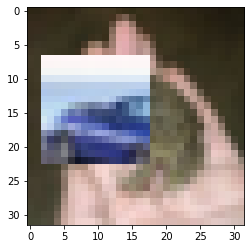

[0.6484375 0.        0.        0.        0.        0.        0.3515625
 0.        0.        0.       ]


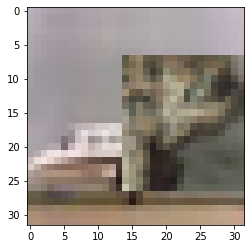

[0.         0.         0.52734375 0.         0.         0.
 0.         0.         0.         0.47265625]


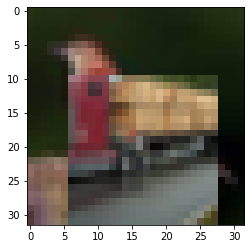

[0.        0.        0.        0.        0.5390625 0.        0.4609375
 0.        0.        0.       ]


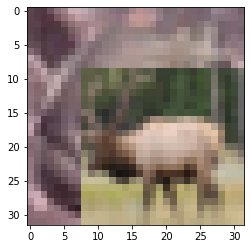

[0.5732422 0.        0.        0.        0.4267578 0.        0.
 0.        0.        0.       ]


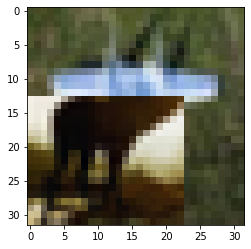

In [ ]:
for images, labels in train_ds.take(5):
    # plt.imshow(images[0])
    plt.imshow(images[0].numpy().astype('uint8'))
    # plt.title(classes[labels[0].numpy()])
    print(labels[0].numpy())
    # print(class)
    plt.show() 


In [ ]:
model = create_model()

In [ ]:
model.compile(keras.optimizers.Adam(LR), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [25]:
model.fit(train_ds, epochs=N_EPOCH)

NameError: name 'model' is not defined

In [15]:
# 사용안함
def cutmix(images, labels):
    imgs = []; labs = []
    for i in range(N_BATCH):
        APPLY = tf.cast(tf.random.uniform(()) >= 0.5, tf.int32)
        idx = tf.random.uniform((), 0, N_BATCH, tf.int32)

        W = RES
        H = RES
        lam = tf.random.uniform(())
        cut_ratio = tf.math.sqrt(1.-lam)
        cut_w = tf.cast(W * cut_ratio, tf.int32) * APPLY
        cut_h = tf.cast(H * cut_ratio, tf.int32) * APPLY

        cx = tf.random.uniform((), int(W/8), int(7/8*W), tf.int32)
        cy = tf.random.uniform((), int(H/8), int(7/8*H), tf.int32)

        xmin = tf.clip_by_value(cx - cut_w//2, 0, W)
        ymin = tf.clip_by_value(cy - cut_h//2, 0, H)
        xmax = tf.clip_by_value(cx + cut_w//2, 0, W)
        ymax = tf.clip_by_value(cy + cut_h//2, 0, H)

        mid_left = images[i, ymin:ymax, :xmin, :]
        mid_mid = images[idx, ymin:ymax, xmin:xmax, :]
        mid_right = images[i, ymin:ymax, xmax:, :]
        middle = tf.concat([mid_left, mid_mid, mid_right], axis=1)
        top = images[i, :ymin, :, :]
        bottom = images[i, ymax:, :, :]
        new_img = tf.concat([top, middle, bottom], axis=0)
        imgs.append(new_img)

        cut_w_mod = xmax - xmin
        cut_h_mod = ymax - ymin
        alpha = tf.cast((cut_w_mod*cut_h_mod)/(W*H), tf.float32)
        label1 = labels[i]
        label2 = labels[idx]
        new_label = ((1-alpha)*label1 + alpha*label2)
        labs.append(new_label)
    new_imgs = tf.reshape(tf.stack(imgs), [-1, RES, RES, 3])
    new_labs = tf.reshape(tf.stack(labs), [-1, N_CLASS])

    return new_imgs, new_labs